In [2]:
import bql
import numpy as np
from IPython.display import display, clear_output
import pandas as pd
import time 
import datetime
from ipywidgets import *
from bqplot import *
from bqplot.interacts import *

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

bq = bql.Service()
d = bq.data
f = bq.func
u = bq.univ

In [3]:
# INPUTS ###############

equity_idx = ['SXXP Index', 'SX5E Index', 'IBEX Index', 'DAX Index', 'CAC Index', 'UKX Index', 'SMI Index', 'SPMIB Index', 'OMX Index', 'LCXP Index', 'MCXP Index',
              'SCXP Index', 'MXEU000V Index', 'MXEU000G Index', 'SPX Index', 'RAY Index', 'CCMP Index', 'NKY Index', 'HSI Index', 'AS51 Index', 'KOSPI Index', 'TWSE Index',
              'IBOV Index', 'SENSEX Index', 'SHCOMP Index', 'MERVAL Index', 'IPSA Index', 'MEXBOL Index', 'PX Index', 'BUX Index', 'JALSH Index', 'SET Index']

index_universe = ['HFRIFOF Index'] + equity_idx

start_date = datetime.datetime(2008,12,31)
end_date = datetime.datetime(2018,12,31)

In [7]:
def bq_res_array_to_pd(res_array):
    a = res_array[0].df().reset_index()
    r_all = pd.DataFrame({'ID':a['ID']})
    for res in res_array:
        r_n = res.df().reset_index()
        r_all = r_all.merge(r_n, on = 'ID')
    return r_all

def norm_corr(as1, as2, st_date, e_date):
    price = d.px_last(start = st_date, end = e_date, per = 'M', fill='prev', currency = 'USD')
    price = f.zscore(price)
    base_price = f.value(price, u.list(as1))
    correlation = f.corr(base_price, price)

    request = bql.Request(as2, {'Cor': correlation}, preferences={'currencycheck':'ignore'}) #There's an error with de currencies of these tickers. This way we "solve" the issue
    res = bq.execute(request)
    cor_res = res[0].df()
    
    return cor_res.iloc[0]['Cor']

def correlDist(corr):
    dist = ((1-corr)/2)**0.5
    return dist

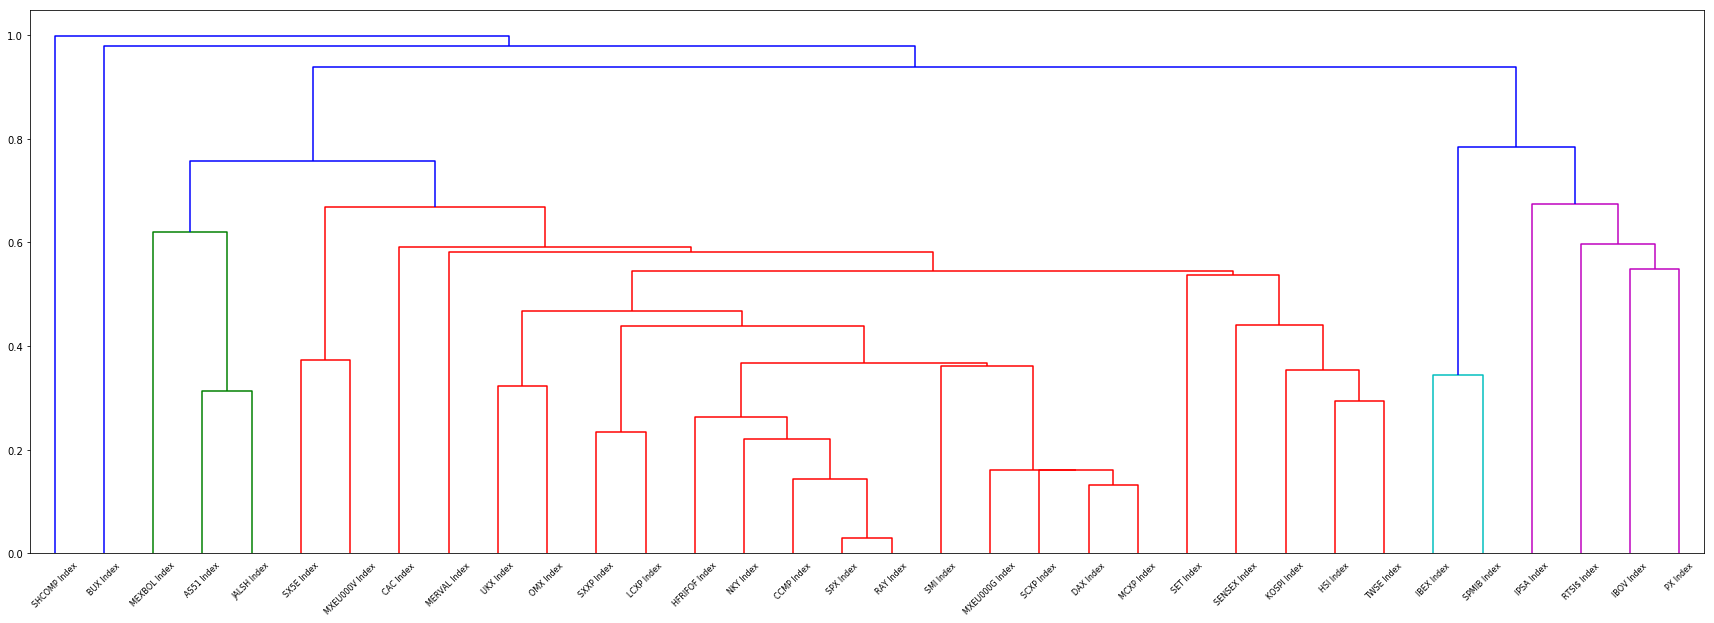

In [4]:
###############    MAIN    ###############

#Calculate Cluster
count = 0
for asset1 in index_universe:
    aux_cor_list=[]
    for asset2 in index_universe:
        aux_cor_list.append(norm_corr(asset1,asset2,start_date,end_date))
        
    if count == 0:
        Correl_Matrix = pd.DataFrame({asset1: pd.Series(aux_cor_list, index = index_universe)})
    else:
        aux_Correl_Matrix = pd.DataFrame({asset1: pd.Series(aux_cor_list, index = index_universe)})
        Correl_Matrix = pd.concat([Correl_Matrix, aux_Correl_Matrix],axis = 1)
        
    count += 1

Z = linkage(correlDist(Correl_Matrix))

plt.figure(figsize=(30, 10), facecolor='w')
dendrogram(Z, labels = index_universe)
plt.show()

In [17]:
# Correl_Matrix.to_excel('RV_cor.xlsx')